In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns
sns.set()
from tqdm import tqdm

import phenalyze as ph

from scipy.optimize import curve_fit
from scipy.special import erfcinv
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scipy.stats import zscore
import math

# import warnings
# warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# Lectura de datos


In [44]:
k_r_list = np.linspace(1,3,10)
h_list = np.linspace(1,4,10)
b_list = np.linspace(1,3,10)

In [45]:
datalist = []

for h_i in h_list:
    for k_r in k_r_list:
        for b_i in b_list:
            df = pd.read_csv(f"Data_RangoParcial/Activadores/RuidoIntrinseco/ActInt_h{h_i:.1f}_kr{k_r:.1f}_b{b_i:.1f}.csv", header=0, index_col=0)
            df.insert(0, "h", [h_i, h_i])
            df.insert(1, "kr", [k_r, k_r])
            df.insert(2, "Beta", [b_i, b_i])
            datalist.append(df)

tint_data = pd.concat(datalist)
tint_data.columns = ['h', 'kr', 'Beta', 'RNA 1', 'Protein 1', 'RNA 2', 'Protein 2', 'RNA 3', 'Protein 3']
display(tint_data)

,h,kr,Beta,RNA 1,Protein 1,RNA 2,Protein 2,RNA 3,Protein 3
Mean,1.0,1.0,1.000000,4.355627,4219.884147,1.877175,1818.982920,2.674633,2595.485668
CV2,1.0,1.0,1.000000,0.229451,0.031389,0.541544,0.078467,0.415254,0.076069
Mean,1.0,1.0,1.222222,4.372774,4236.822858,2.303026,2230.811449,3.106279,3010.879310
CV2,1.0,1.0,1.222222,0.229475,0.031630,0.444610,0.065407,0.352022,0.061942
Mean,1.0,1.0,1.444444,4.365185,4229.280240,2.716578,2633.559073,3.486861,3386.125397
...,...,...,...,...,...,...,...,...,...
CV2,4.0,3.0,2.555556,0.076334,0.010447,0.093780,0.012994,0.101189,0.014363
Mean,4.0,3.0,2.777778,13.095932,12688.404242,11.658871,11303.085035,10.262542,9949.761918
CV2,4.0,3.0,2.777778,0.076131,0.010371,0.085950,0.011851,0.098323,0.013825
Mean,4.0,3.0,3.000000,13.077385,12677.721248,12.599923,12218.552151,10.432108,10113.535299


In [46]:
datalist = []

for h_i in h_list:
    for k_r in k_r_list:
        for b_i in b_list:
            df = pd.read_csv(f"Data_RangoParcial/Activadores/RuidoNeto/ActGlob_h{h_i:.1f}_kr{k_r:.1f}_b{b_i:.1f}.csv", header=0, index_col=0)
            df = df.T
            df.insert(0, "h", [h_i, h_i])
            df.insert(1, "kr", [k_r, k_r])
            df.insert(2, "Beta", [b_i, b_i])
            datalist.append(df)

tnet_data = pd.concat(datalist)
tnet_data.columns = ['h', 'kr', 'Beta', 'RNA 1', 'Protein 1', 'RNA 2', 'Protein 2', 'RNA 3', 'Protein 3']
display(tnet_data)

,h,kr,Beta,RNA 1,Protein 1,RNA 2,Protein 2,RNA 3,Protein 3
Mean,1.0,1.0,1.000000,4.362247,4225.386915,1.899171,1840.190390,2.737285,2652.887150
CV2,1.0,1.0,1.000000,0.282932,0.061421,0.630421,0.138382,0.543079,0.169048
Mean,1.0,1.0,1.222222,4.363502,4230.420500,2.320890,2247.972416,3.169097,3068.523500
CV2,1.0,1.0,1.222222,0.283374,0.061648,0.534511,0.125462,0.479981,0.154365
Mean,1.0,1.0,1.444444,4.365927,4229.562584,2.742125,2657.169478,3.549201,3444.157836
...,...,...,...,...,...,...,...,...,...
CV2,4.0,3.0,2.555556,0.130058,0.040358,0.158789,0.051375,0.188304,0.068414
Mean,4.0,3.0,2.777778,13.095900,12687.202583,11.580288,11233.460218,10.093776,9802.217596
CV2,4.0,3.0,2.777778,0.130507,0.040580,0.151398,0.050286,0.176864,0.061502
Mean,4.0,3.0,3.000000,13.090338,12688.433344,12.514029,12140.520759,10.301040,10002.311231


In [47]:
tres_int = tint_data.loc["CV2"]
tres_net = tnet_data.loc["CV2"]

dos_int = tres_int.loc[tres_int.Beta==b_list[6]][['h', 'kr', 'RNA 1', 'Protein 1', 'RNA 2', 'Protein 2']]
dos_net = tres_net.loc[tres_net.Beta==b_list[6]][['h', 'kr', 'RNA 1', 'Protein 1', 'RNA 2', 'Protein 2']]


dos_efc = dos_net.copy()
dos_efc["RNA 2"] = dos_net["RNA 2"] - dos_int["RNA 2"]
dos_efc["Protein 2"] = dos_net["Protein 2"] - dos_int["Protein 2"]

tres_efc = tres_net.copy()
tres_efc["RNA 3"] = tres_net["RNA 3"] - tres_int["RNA 3"]
tres_efc["Protein 3"] = tres_net["Protein 3"] - tres_int["Protein 3"]

# Bootstrap

In [48]:
def BootstrapFit(h_list:list, data:pd.DataFrame, model:callable, seed:list, lims:list):
    params_tensor = []
    err_tensor = []
    R2_tensor = []
    if len(data.columns)==9: #Tres Genes
        for h_i in h_list:
            new_data = data.loc[data.h==h_i]
            noise1 = new_data["Protein 1"].to_numpy()
            noise2 = new_data["Protein 2"].to_numpy()
            noise3 = new_data["Protein 3"].to_numpy()

            params_list = []
            err_list = []
            R2_list = []
            for i in tqdm(range(1000)):
                ii_random = np.random.choice(len(noise1),len(noise1))
                new_noise1 = noise1[ii_random]
                new_noise2 = noise2[ii_random]
                new_noise3 = noise3[ii_random]

                params, cov = curve_fit(f = model, xdata = [new_noise1, new_noise2], ydata = new_noise3, p0=seed[np.where(h_list==h_i)[0][0]], bounds=lims, maxfev=10000000)
                params_list.append(params)

                err = np.sqrt(2)*erfcinv(2*(1-0.95))*np.sqrt(np.diag(cov))
                err_list.append(err)

                Rsquared = r2_score(new_noise3, model([new_noise1, new_noise2], *params))
                R2_list.append(Rsquared)

            params_tensor.append(params_list)
            err_tensor.append(err_list)
            R2_tensor.append(R2_list)

    elif len(data.columns)==6: # Dos Genes
        for h_i in h_list:
            new_data = data.loc[data.h==h_i]
            noise1 = new_data["Protein 1"].to_numpy()
            noise2 = new_data["Protein 2"].to_numpy()

            params_list = []
            err_list = []
            R2_list = []
            for i in tqdm(range(1000)):
                ii_random = np.random.choice(len(noise1),len(noise1))
                new_noise1 = noise1[ii_random]
                new_noise2 = noise2[ii_random]

                params, cov = curve_fit(f = model, xdata = new_noise1 , ydata = new_noise2, p0=seed[np.where(h_list==h_i)[0][0]], bounds=lims, maxfev=10000000)
                params_list.append(params)

                err = np.sqrt(2)*erfcinv(2*(1-0.95))*np.sqrt(np.diag(cov))
                err_list.append(err)

                Rsquared = r2_score(new_noise2, model(new_noise1, *params))
                R2_list.append(Rsquared)

            params_tensor.append(params_list)
            err_tensor.append(err_list)
            R2_tensor.append(R2_list)

    else:
        print("El DataFrame de entrada no tiene la estructura esperada.")

    return np.array(params_tensor), np.array(err_tensor), np.array(R2_tensor)

In [49]:
def weited_mean(x,σ2):
    w = 1/(σ2+1)
    sum_mean = np.sum(w*x)
    sum_var = np.sum(w)
    return [sum_mean/sum_var, 1/sum_var]

In [50]:
def bootstrap_filter(ParamsTensor, ErrTensor, R2Tensor):
    NewParamsTensor = []
    NewErrTensor = []
    NewR2Tensor = []

    for i in range(np.shape(R2Tensor)[0]):
        kde = gaussian_kde(R2Tensor[i])
        # x_line = np.linspace(min(R2Tensor[i]), max(R2Tensor[i]), 1000)
        x_line = np.sort(R2Tensor[i])
        x_valleys = [0] + list(find_peaks(-kde(x_line))[0])

        NewParamsTensor.append(ParamsTensor[i, R2Tensor[i]>=x_line[x_valleys[-1]], :])
        NewErrTensor.append(ErrTensor[i, R2Tensor[i]>=x_line[x_valleys[-1]], :])
        NewR2Tensor.append(R2Tensor[i, R2Tensor[i]>=x_line[x_valleys[-1]]])

    return NewParamsTensor, NewErrTensor, NewR2Tensor
    # return ParamsTensor, ErrTensor, R2Tensor



def plot_filter(R2Tensor, lines=False, curve=False, filtred_hist=True):
    fig = plt.figure(figsize=(12,6))

    for i in range(10):
        fig.add_subplot(3,4,i+1)
        kde = gaussian_kde(R2Tensor[i])

        x_line = np.linspace(min(R2Tensor[i]), max(R2Tensor[i]), 1000)
        if curve:
            plt.plot(x_line, kde(x_line))
        x_valleys = [0] + list(find_peaks(-kde(x_line))[0])

        _ = plt.hist(R2Tensor[i], density=True, bins=100, linewidth=0.0001)
        if filtred_hist:
            _ = plt.hist(R2Tensor[i][R2Tensor[i]>x_line[x_valleys[-1]]], density=True, linewidth=0.0001, alpha=0.9)
        if lines:
            [plt.axvline(xi, color="black") for xi in x_line[find_peaks(-kde(x_line))[0]]]

In [51]:
def plot_bootstrap(ParamsTensor, ErrTensor, R2Tensor, labels, dims, fig_size=(12,5), title="Figura sin título"):
    # ParamsTensor, ErrTensor, R2Tensor = bootstrap_filter(ParamsTensor,ErrTensor,R2Tensor)

    fig = plt.figure(figsize=fig_size)
    estimadores = []
    incertidumbres = []
    for i_plot in range(len(labels)):
        means_list = []
        stds_list = []
    
        ax = fig.add_subplot(dims[0], dims[1],i_plot+1)
        for i_h in range(len(h_list)):
            ii_ErrorFinito = np.isfinite(ErrTensor[i_h][:,i_plot])
            means, stds = weited_mean(ParamsTensor[i_h][:,i_plot][ii_ErrorFinito], ErrTensor[i_h][:,i_plot][ii_ErrorFinito])
            means_list.append(means)
            stds_list.append(1.96*stds)

        im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")
        plt.colorbar(im, ax=ax, label="Weight")
        
        ax.errorbar(x=h_list, y=np.array(means_list), yerr=np.array(stds_list), ecolor='black', alpha=0.5, capsize=5, fmt=" ")
    
        ax.set_ylabel(labels[i_plot])#, fontsize=15)
        ax.set_xlabel(r"$h$")#, fontsize=15)
        # plt.xticks(fontsize=15)
        # plt.yticks(fontsize=15)
        
        estimadores.append(means_list)
        incertidumbres.append(stds_list)
    plt.suptitle(title)#, fontsize=20)
    plt.tight_layout()
    # plt.savefig("GraficasParaGuardar/CORRECCIONACTPARAMS"+title.replace(' ','').replace('$','').replace('\e','e')+".png")

    return estimadores, incertidumbres


def plot_R2(ParamsTensor, ErrTensor, R2Tensor, title="Figura sin título"):
    # ParamsTensor, ErrTensor, R2Tensor = bootstrap_filter(ParamsTensor,ErrTensor,R2Tensor)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    _ = ax.boxplot(np.array(R2Tensor).T, positions=h_list.round(2), widths=0.2)
    ax.set_ylabel(r"$R^2$")
    ax.set_xlabel(r"$h$")
    ax.set_ylim(0,1.1)
    fig.suptitle(title)
    # plt.savefig("GraficasParaGuardar/CORRECCIONACTR2"+title.replace(' ','').replace('$','').replace('\e','e')+".png")

# Dos genes

### Intrínseco

In [52]:
def model(x, A, b, C):
    return A*np.exp(b*x) + C

n_params = 3
bounds_dosint = ((n_params-1)*[-np.inf]+[0.0], n_params*[np.inf])

seeds_df = pd.read_csv("ActivatorsDefinitiveSeeds.csv", index_col=0)
semilla_dosint = 10*[[eval(i) for i in seeds_df["2 genes"]["Intrinsic"].strip("][").split(" ") if i!=""]]

# ParamsTensorDosInt, ErrTensorDosInt, R2TensorDosInt = BootstrapFit(h_list, dos_int, model, semilla_dosint, bounds_dosint)
# np.savez("Bootstrap_IntrinsecoDosActivadores", params=ParamsTensorDosInt, errs=ErrTensorDosInt, R2=R2TensorDosInt)

In [53]:
bootstrap_data = np.load("Bootstrap_IntrinsecoDosActivadores.npz")
ParamsTensorDosInt, ErrTensorDosInt, R2TensorDosInt = bootstrap_data["params"], bootstrap_data["errs"], bootstrap_data["R2"]

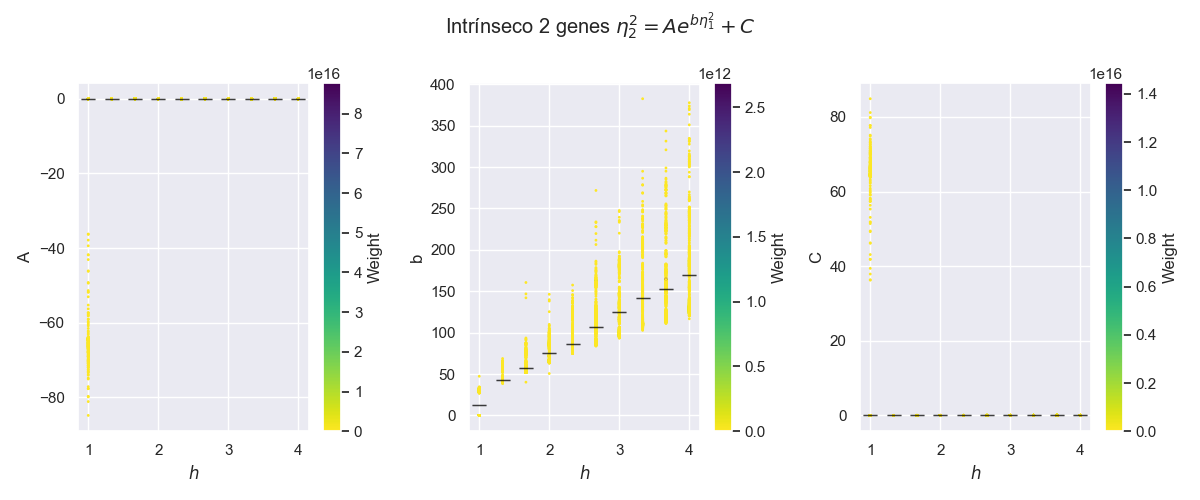

In [54]:
labels = ["A", "b", "C"]
EstimatorsDosInt, UncertaintiesDosInt = plot_bootstrap(ParamsTensorDosInt, ErrTensorDosInt, R2TensorDosInt, labels, (1,3), title=fr"Intrínseco 2 genes $\eta_2^2 = Ae^{{b \eta_1^2}} + C$")

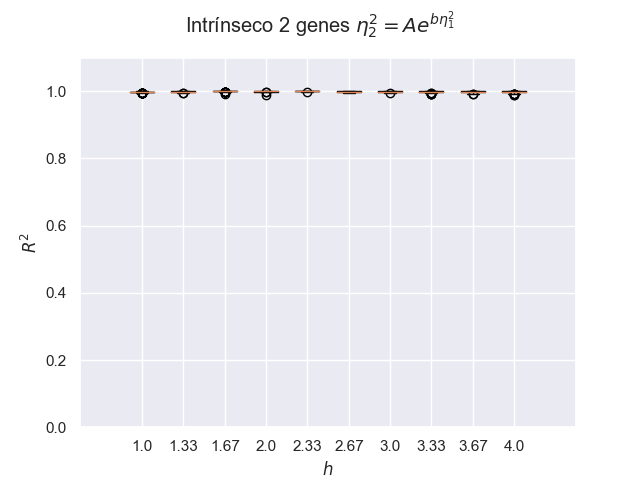

In [55]:
plot_R2(ParamsTensorDosInt, ErrTensorDosInt, R2TensorDosInt, title=fr"Intrínseco 2 genes $\eta_2^2 = Ae^{{b \eta_1^2}}$")

### Global efectivo

In [56]:
def model(x , A, b, C):
    return A*(x**b) + C

n_params = 3
bounds_dosefc = ((n_params-1)*[-np.inf]+[0.0], n_params*[np.inf])

seeds_df = pd.read_csv("ActivatorsDefinitiveSeeds.csv", index_col=0)
semilla_dosefc = 10*[[eval(i) for i in seeds_df["2 genes"]["Global"].strip("][").split(" ") if i!=""]]

# ParamsTensorDosEfc, ErrTensorDosEfc, R2TensorDosEfc = BootstrapFit(h_list, dos_efc, model, semilla_dosefc, bounds_dosefc)
# np.savez("Bootstrap_GlobalDosActivadores", params=ParamsTensorDosEfc, errs=ErrTensorDosEfc, R2=R2TensorDosEfc)

In [57]:
bootstrap_data = np.load("Bootstrap_GlobalDosActivadores.npz")
ParamsTensorDosEfc, ErrTensorDosEfc, R2TensorDosEfc = bootstrap_data["params"], bootstrap_data["errs"], bootstrap_data["R2"]

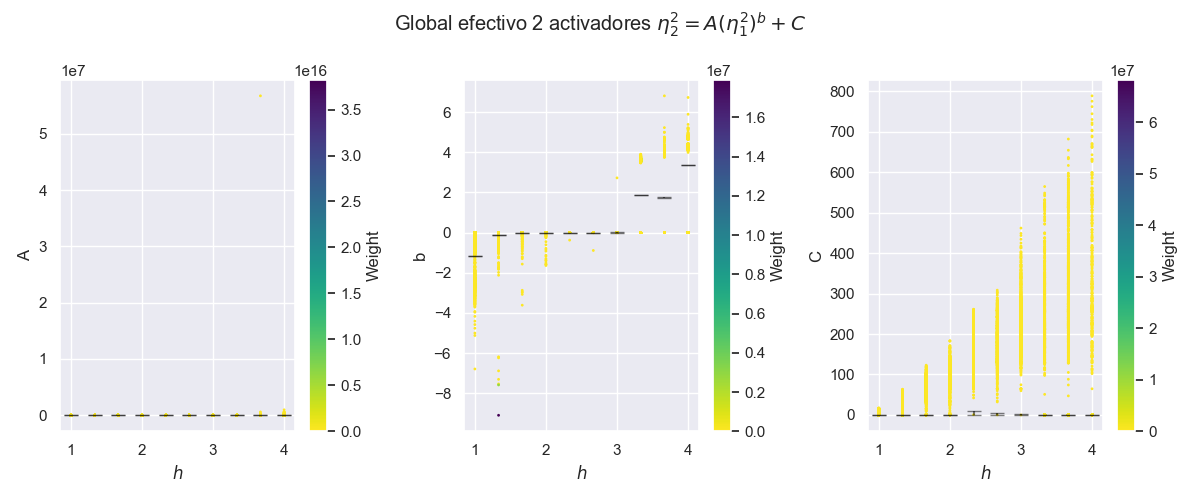

In [58]:
labels = ["A", "b", "C"]
EstimatorsDosEfc, UncertaintiesDosEfc = plot_bootstrap(ParamsTensorDosEfc, ErrTensorDosEfc, R2TensorDosEfc, labels, (1,3), title=fr"Global efectivo 2 activadores $\eta_2^2 = A (\eta_1^2)^b + C $")

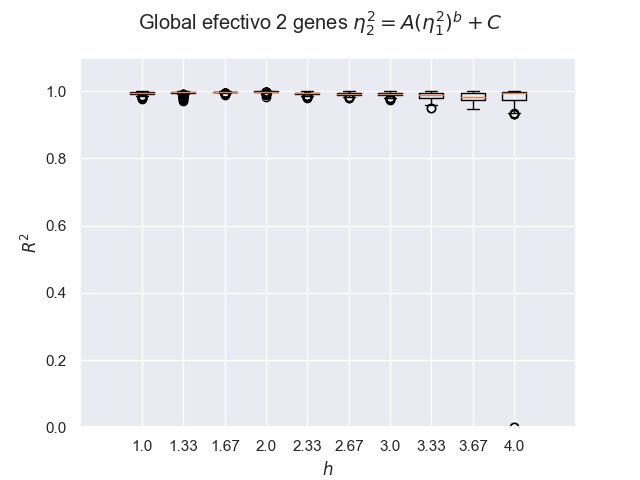

In [59]:
plot_R2(ParamsTensorDosEfc, ErrTensorDosEfc, R2TensorDosEfc, title=fr"Global efectivo 2 genes $\eta_2^2 = A (\eta_1^2)^b + C $")

# Tres genes

### Intrínseco

In [60]:
def model(data, A, b, C, d, K):
    x, y = data
    return A*np.exp(b*x) + C*np.exp(d*y) + K

n_params = 5
bounds_tresint = ((n_params-1)*[-np.inf]+[0.0], n_params*[np.inf])

seeds_df = pd.read_csv("ActivatorsDefinitiveSeeds.csv", index_col=0)
semilla_tresint = 10*[[eval(i) for i in seeds_df["3 genes"]["Intrinsic"].strip("][").split(" ") if i!=""]]

# ParamsTensorTresInt, ErrTensorTresInt, R2TensorTresInt = BootstrapFit(h_list, tres_int, model, semilla_tresint, bounds_tresint)
# np.savez("Bootstrap_IntrinsecoTresActivadores", params=ParamsTensorTresInt, errs=ErrTensorTresInt, R2=R2TensorTresInt)

In [61]:
bootstrap_data = np.load("Bootstrap_IntrinsecoTresActivadores.npz")
ParamsTensorTresInt, ErrTensorTresInt, R2TensorTresInt = bootstrap_data["params"], bootstrap_data["errs"], bootstrap_data["R2"]

C:\Users\aleja\AppData\Local\Temp\ipykernel_9816\628193647.py:18: RuntimeWarning: divide by zero encountered in divide
  im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")


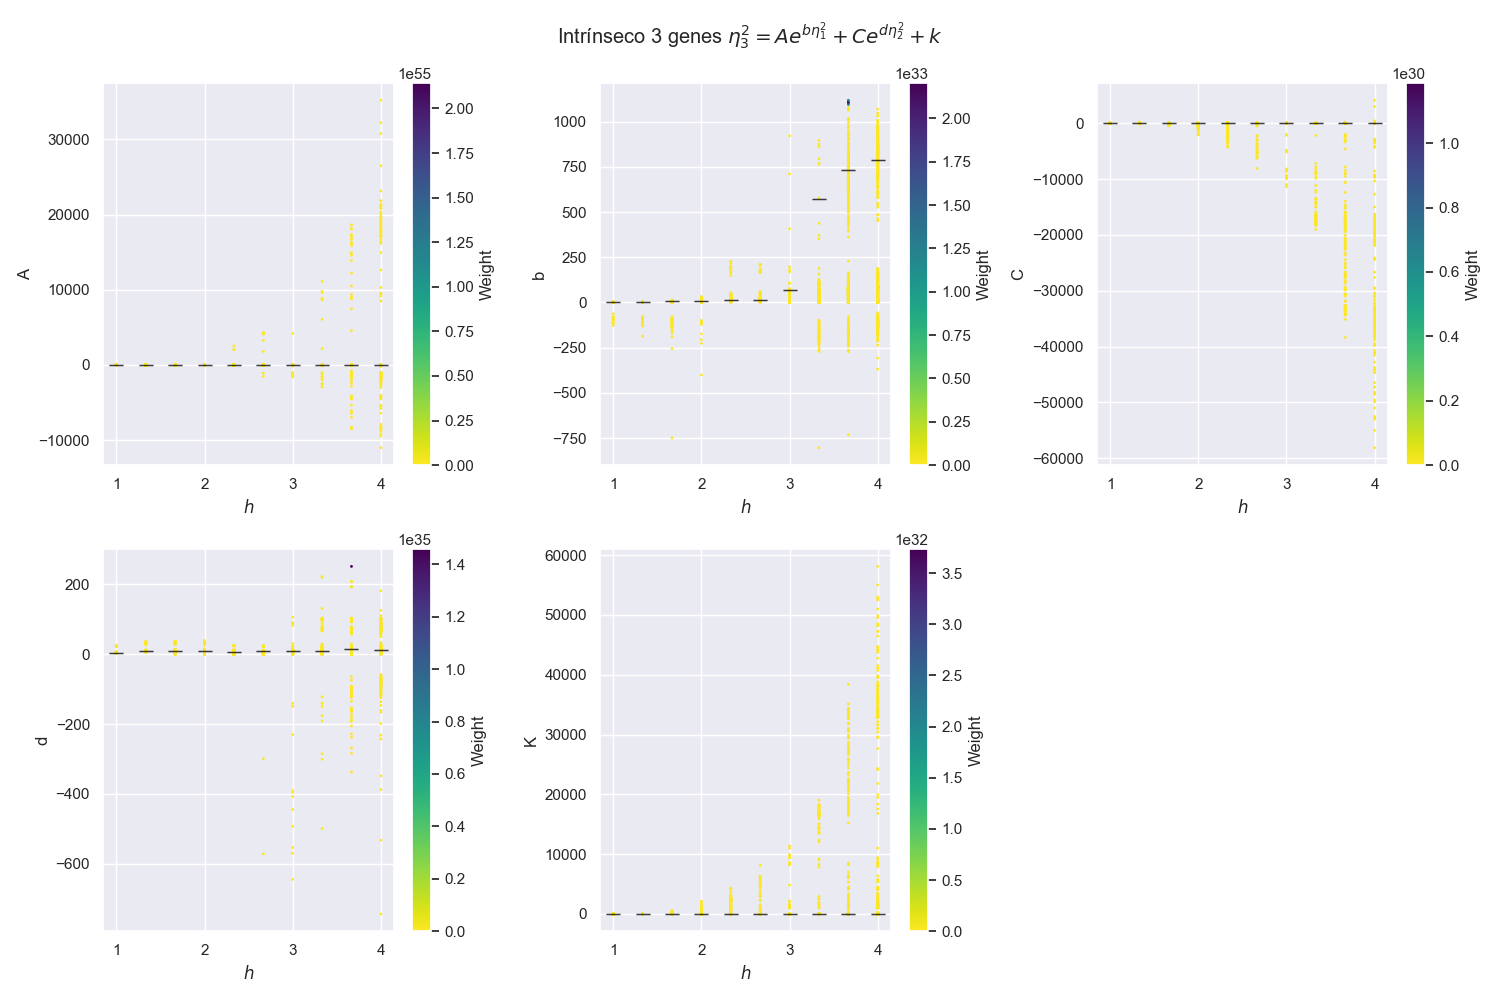

In [62]:
labels = ["A", "b", "C", "d", "K"]
EstimatorsTresInt, UncertaintiesTresInt = plot_bootstrap(ParamsTensorTresInt, ErrTensorTresInt, R2TensorTresInt, labels, (2,3), title=fr"Intrínseco 3 genes $\eta_3^2 = A e^{{b \eta_1^2}} + C e^{{d \eta_2^2}} + k$", fig_size=(15,10))

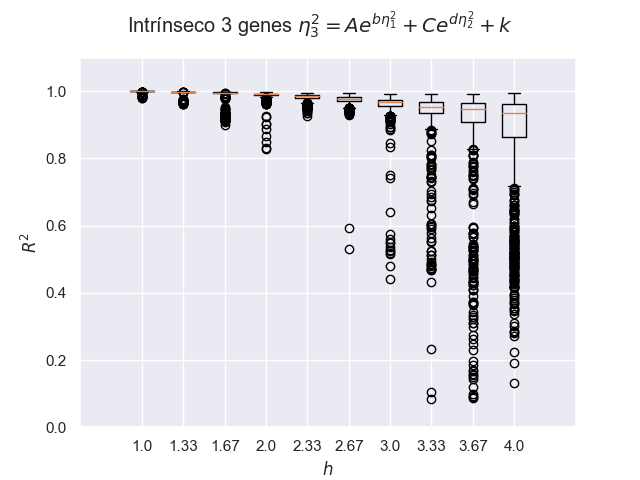

In [63]:
plot_R2(ParamsTensorTresInt, ErrTensorTresInt, R2TensorTresInt, title=fr"Intrínseco 3 genes $\eta_3^2 = A e^{{b \eta_1^2}} + C e^{{d \eta_2^2}} + k$")

### Global efectivo

In [64]:
def model(data, A, b, C, d, K):
    x, y = data
    return A*(x**b) + C*(y**d) + K

n_params = 5
bounds_tresefc = ((n_params-1)*[-np.inf]+[0.0], n_params*[np.inf])

seeds_df = pd.read_csv("ActivatorsDefinitiveSeeds.csv", index_col=0)
semilla_tresefc = 10*[[eval(i) for i in seeds_df["3 genes"]["Global"].strip("][").split(" ") if i!=""]]

# ParamsTensorTresEfc, ErrTensorTresEfc, R2TensorTresEfc = BootstrapFit(h_list, tres_efc, model, semilla_tresefc, bounds_tresefc)
# np.savez("Bootstrap_GlobalTresActivadores", params=ParamsTensorTresEfc, errs=ErrTensorTresEfc, R2=R2TensorTresEfc)

In [65]:
bootstrap_data = np.load("Bootstrap_GlobalTresActivadores.npz")
ParamsTensorTresEfc, ErrTensorTresEfc, R2TensorTresEfc = bootstrap_data["params"], bootstrap_data["errs"], bootstrap_data["R2"]

C:\Users\aleja\AppData\Local\Temp\ipykernel_9816\628193647.py:18: RuntimeWarning: divide by zero encountered in divide
  im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")


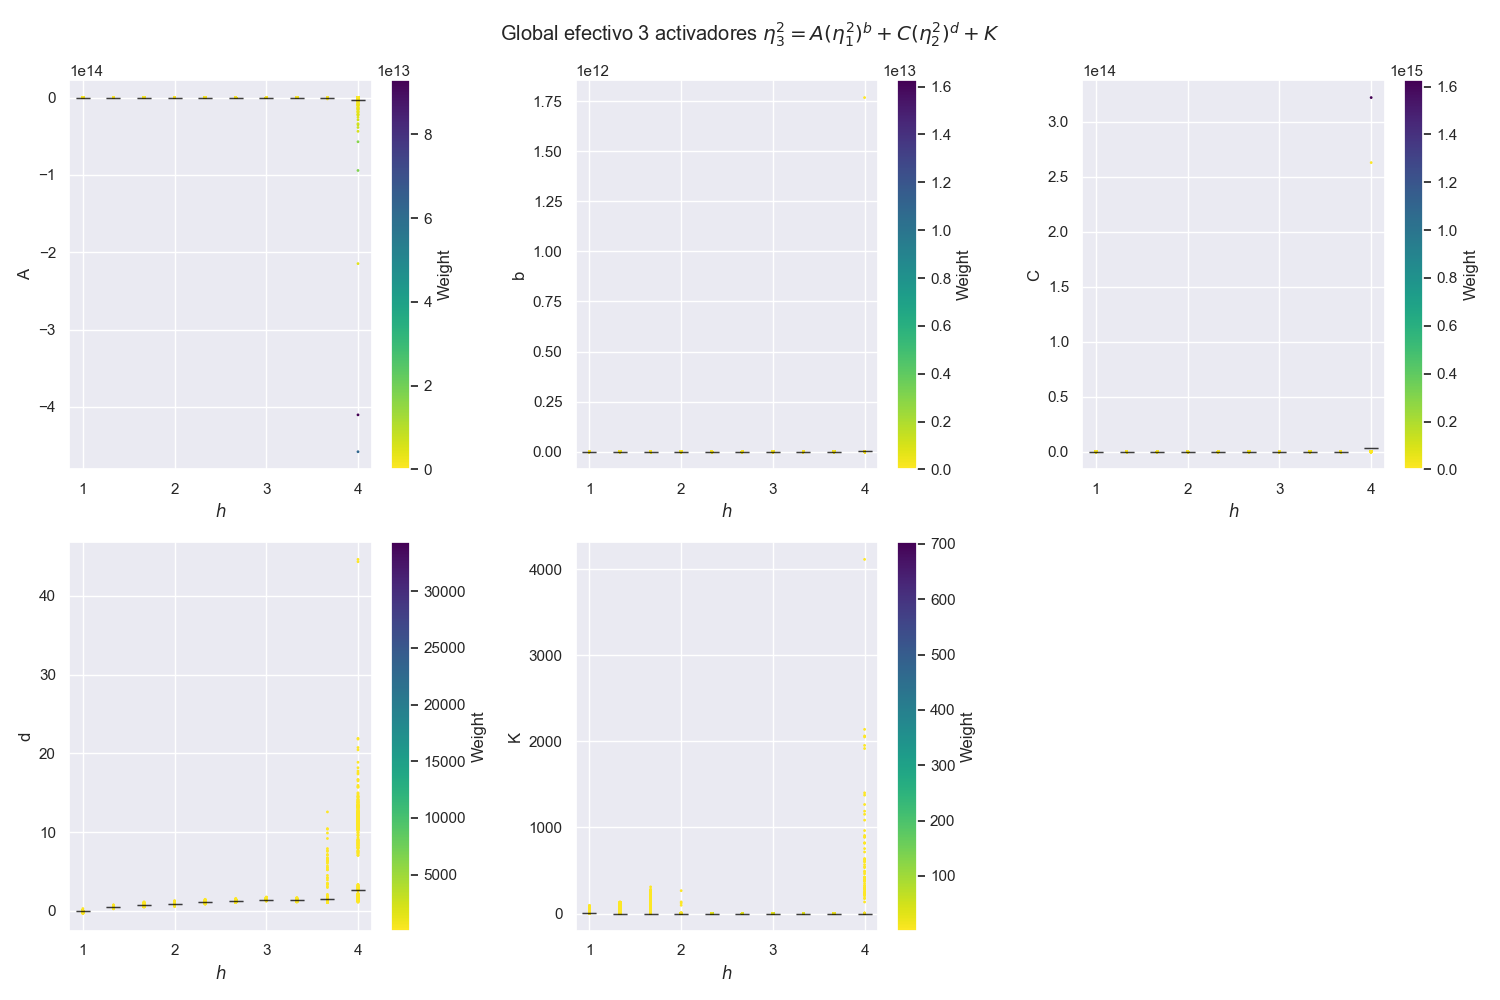

In [66]:
labels = ["A", "b", "C", "d", "K"]
EstimatorsTresEfc, UncertaintiesTresEfc = plot_bootstrap(ParamsTensorTresEfc, ErrTensorTresEfc, R2TensorTresEfc, labels, (2,3), title=fr"Global efectivo 3 activadores $\eta_3^2 = A (\eta_1^2)^b + C (\eta_2^2)^d + K $", fig_size=(15,10))

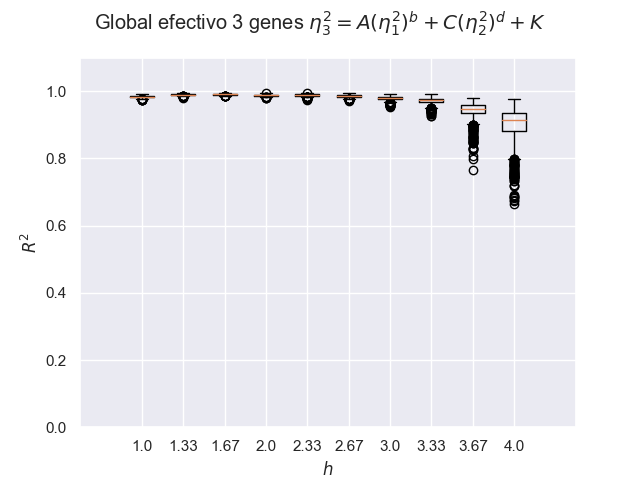

In [67]:
plot_R2(ParamsTensorTresEfc, ErrTensorTresEfc, R2TensorTresEfc, title=fr"Global efectivo 3 genes $\eta_3^2 = A (\eta_1^2)^b + C (\eta_2^2)^d + K $")

# Results

In [68]:
np.savez("R2_Activators", DosInt=R2TensorDosInt, DosGlob=R2TensorDosEfc, TresInt=R2TensorTresInt, TresGlob=R2TensorTresEfc)

In [69]:
Models = ["Intrínseco 2 genes: n2 = Ae^(b n1) + C", "Global efectivo 2 genes: n2 = A n1^b", "Intrínseco 3 genes n3: = A e^(b n1) + C e^(d n2) + k", "Global efectivo 3 genes: n3^2 = A n1^b + C n2^d"]
ParamsNotation = ["A", "b", "C", "d", "K"]
Estimators = [EstimatorsDosInt, EstimatorsDosEfc, EstimatorsTresInt, EstimatorsTresEfc]
Uncertainties = [UncertaintiesDosInt, UncertaintiesDosEfc, UncertaintiesTresInt, UncertaintiesTresEfc]

for i in range(4):
    Estimators[i] = np.array(Estimators[i] + (5-len(Estimators[i]))*[10*["-"]]).T
    Uncertainties[i] = np.array(Uncertainties[i] + (5-len(Uncertainties[i]))*[10*["-"]]).T

# ReportingMatrix = [[str(Estimators[i_model][i_h][i_param])+" +/- "+str(Uncertainties[i_model][i_h][i_param]) for i_param in range(5) for i_h in range(10)] for i_model in range(4)]

ReportingMatrix = []
for i_model in range(4):
    ModelReport = []
    for i_param in range(5):
        for i_h in range(10):
            try:
                n_round = max(math.ceil(-math.log10(Uncertainties[i_model][i_h][i_param].astype(float))), math.ceil(-math.log10(abs(Estimators[i_model][i_h][i_param].astype(float)))))
                est = round(Estimators[i_model][i_h][i_param].astype(float), n_round)
                unc = round(Uncertainties[i_model][i_h][i_param].astype(float), n_round)
                ModelReport.append(str(est)+" +/- "+str(unc)) 
            except:
                ModelReport.append("--") 
    ReportingMatrix.append(ModelReport)


index = [np.repeat(ParamsNotation, 10), np.array(5*list(h_list)).round(1)]

ResultsAct = pd.DataFrame(np.array(ReportingMatrix).T, index=index)
ResultsAct.columns=Models

ResultsAct.to_csv("ParametrosActivadores.csv")

ResultsAct

Intrínseco 2 genes: n2 = Ae^(b n1) + C  \
A 1.0                        0.013 +/- 0.003   
  1.3                        0.012 +/- 0.002   
  1.7                        0.009 +/- 0.002   
  2.0                        0.007 +/- 0.002   
  2.3                        0.005 +/- 0.002   
  2.7                        0.004 +/- 0.002   
  3.0                        0.003 +/- 0.002   
  3.3                        0.003 +/- 0.002   
  3.7                        0.003 +/- 0.002   
  4.0                        0.002 +/- 0.002   
b 1.0                         12.33 +/- 0.02   
  1.3                         42.86 +/- 0.01   
  1.7                         56.67 +/- 0.01   
  2.0                         75.62 +/- 0.01   
  2.3                         86.82 +/- 0.01   
  2.7                        107.01 +/- 0.02   
  3.0                        125.14 +/- 0.02   
  3.3                        141.25 +/- 0.02   
  3.7                        153.24 +/- 0.02   
  4.0                         169.2 +/- 0.03   
C 1.0                        0.002 +/- 0.003   
  1.3                       0.0005 +/- 0.002   
  1.7                        0.001 +/- 0.002   
  2.0                        0.003 +/- 0.002   
  2.3                        0.002 +/- 0.002   
  2.7                        0.003 +/- 0.002   
  3.0                        0.003 +/- 0.002   
  3.3                        0.004 +/- 0.002   
  3.7                        0.004 +/- 0.002   
  4.0                        0.004 +/- 0.002   
d 1.0                                     --   
  1.3                                     --   
  1.7                                     --   
  2.0                                     --   
  2.3                                     --   
  2.7                                     --   
  3.0                                     --   
  3.3                                     --   
  3.7                                     --   
  4.0                                     --   
K 1.0                                     --   
  1.3                                     --   
  1.7                                     --   
  2.0                                     --   
  2.3                                     --   
  2.7                                     --   
  3.0                                     --   
  3.3                                     --   
  3.7                                     --   
  4.0                                     --   

      Global efectivo 2 genes: n2 = A n1^b  \
A 1.0                     -0.015 +/- 0.003   
  1.3                       -0.12 +/- 0.02   
  1.7                        -0.2 +/- 0.05   
  2.0                         -0.4 +/- 0.1   
  2.3                         -4.0 +/- 4.0   
  2.7                         -2.0 +/- 2.0   
  3.0                     -100.0 +/- 300.0   
  3.3                      4500.0 +/- 40.0   
  3.7                    14100.0 +/- 200.0   
  4.0                    41700.0 +/- 200.0   
b 1.0                     -1.159 +/- 0.004   
  1.3                     -0.126 +/- 0.003   
  1.7                     -0.031 +/- 0.003   
  2.0                     -0.015 +/- 0.003   
  2.3                     -0.002 +/- 0.004   
  2.7                     -0.002 +/- 0.004   
  3.0                    0.0007 +/- 0.0042   
  3.3                      1.867 +/- 0.004   
  3.7                      1.745 +/- 0.005   
  4.0                      3.353 +/- 0.004   
C 1.0                      0.104 +/- 0.003   
  1.3                        0.29 +/- 0.02   
  1.7                        0.42 +/- 0.05   
  2.0                          0.7 +/- 0.1   
  2.3                          5.0 +/- 5.0   
  2.7                          3.0 +/- 3.0   
  3.0                          1.0 +/- 2.0   
  3.3                      0.001 +/- 0.005   
  3.7                      0.002 +/- 0.006   
  4.0                    0.0008 +/- 0.0032   
d 1.0                                   --   
  1.3                                   --   
  1.7                                  

In [70]:
np.save("EstimadoresActivadores", Estimators)